In [1]:
#####
# test notebook to make sure simulation functions work
#####

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from simulation_functions import (
    simulate_streams_and_liquidations, 
    calculate_pl, 
    simulate_and_calculate_pl, 
    calculate_liquidator_pl_with_prediction
)

from simulation_parameters import sample_params
from graphing_utils import graph_pl

In [2]:
from line_profiler import LineProfiler
lp = LineProfiler()

In [3]:
def clean_imported_df(df):
    df = df.drop(columns=['Unnamed: 0'])
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = pd.to_datetime(df['date'])
    return df

In [4]:
df = clean_imported_df(pd.read_csv('gas_prices_since_march_2020.csv'))

In [5]:
params = {'upfront_fee': 0,  # eth
 'monthly_opened_streams': 500,
 'average_stream_lifetime': 10,  # days
 'percent_accidently_liquidated_per_month': 20,
 'average_stream_size': 1000,  # usd
 'liquidator_capital': 20000,
 'upfront_hours': 0,
 'refund_rate': .5,  # fraction
 'gas_tank_size': 20,
 'max_days_to_return': 7,
 'max_liquidation_wait_time': 24,
 'min_self_liquidation_savings': 0,
 'gas_prediction_ability': 1}  # in hours - minimum value of 3 minutes

In [6]:
df = simulate_streams_and_liquidations(df, params)

In [7]:
df = calculate_pl(df, params)

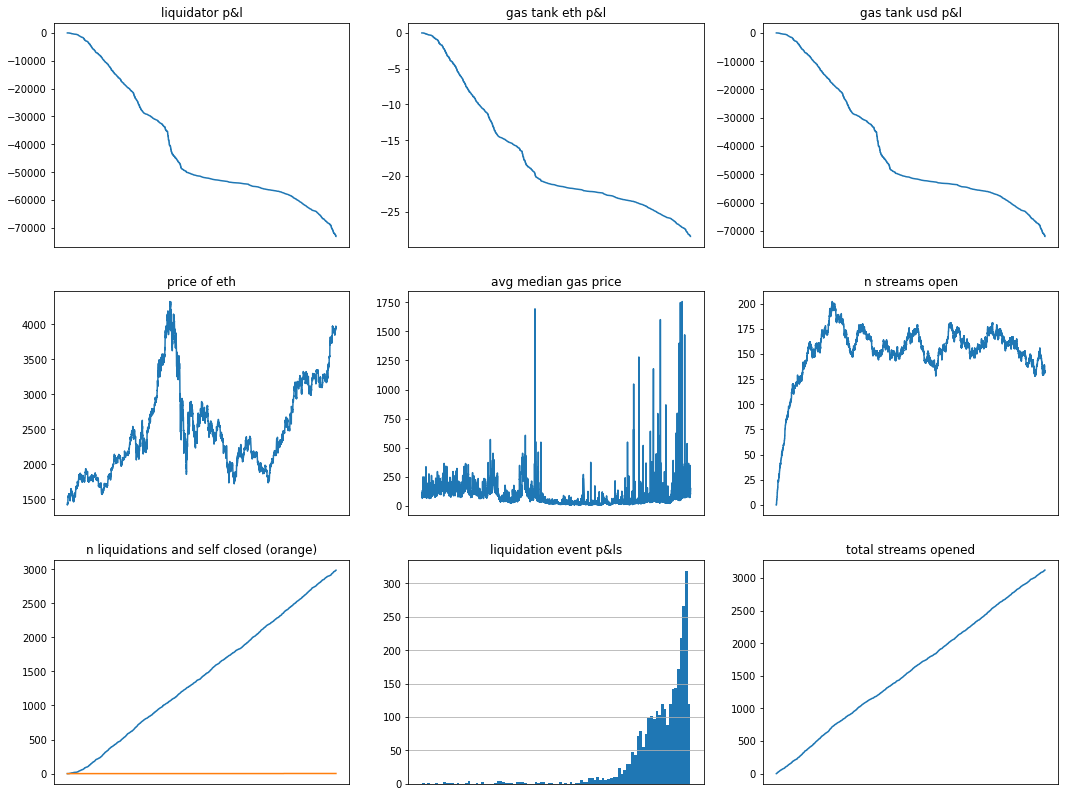

In [8]:
graph_pl(df)

In [9]:
incurred_cost_per_tx = np.sum(df['gas_tank_eth_pl']) / (np.sum(df['n_self_closed']) + np.sum(df['n_liquidated'])) * 2 # for specific run above
print(incurred_cost_per_tx)

-0.019048648543872095


In [10]:
lp_wrapper = lp(simulate_streams_and_liquidations)
lp_wrapper(df, params)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 0.007213 s
File: /Users/mcurcio/Desktop/superfluid-liquidations/simulation_functions.py
Function: simulate_streams_and_liquidations at line 157

Line #      Hits         Time  Per Hit   % Time  Line Contents
   157                                           def simulate_streams_and_liquidations(df, params):
   158                                               """ simulates streams and liquidations data """
   159         1         20.0     20.0      0.3      n_minutes = df.shape[0]
   160         2       1721.0    860.5     23.9      new_stream_times, liquidation_times, self_closed_times, liquidation_sizes, self_closed_sizes = simulate_streams(df,
   161         1          1.0      1.0      0.0                                                                                                                      params)
   162                                           
   163         1       1226.0   1226.0     17.0      df['n_opened'] = bin_times_and_sizes

In [11]:
lp_wrapper = lp(calculate_pl)
lp_wrapper(df, params)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 0.007213 s
File: /Users/mcurcio/Desktop/superfluid-liquidations/simulation_functions.py
Function: simulate_streams_and_liquidations at line 157

Line #      Hits         Time  Per Hit   % Time  Line Contents
   157                                           def simulate_streams_and_liquidations(df, params):
   158                                               """ simulates streams and liquidations data """
   159         1         20.0     20.0      0.3      n_minutes = df.shape[0]
   160         2       1721.0    860.5     23.9      new_stream_times, liquidation_times, self_closed_times, liquidation_sizes, self_closed_sizes = simulate_streams(df,
   161         1          1.0      1.0      0.0                                                                                                                      params)
   162                                           
   163         1       1226.0   1226.0     17.0      df['n_opened'] = bin_times_and_sizes

In [12]:
# show effect of prediciton on gas price paid
refund_rate_to_costs = []
for refund_rate in [.1, .3, .5, .7, .9]:
    params['refund_rate'] = refund_rate
    incurred_cost_per_tx = []
    for pred in np.linspace(0,4, 17):
        params['gas_prediction_ability'] = pred
        df = calculate_pl(df, params)
        incurred_cost_per_tx.append(np.sum(df['gas_tank_eth_pl']) / (np.sum(df['n_self_closed']) + np.sum(df['n_liquidated'])))
    refund_rate_to_costs.append(incurred_cost_per_tx)

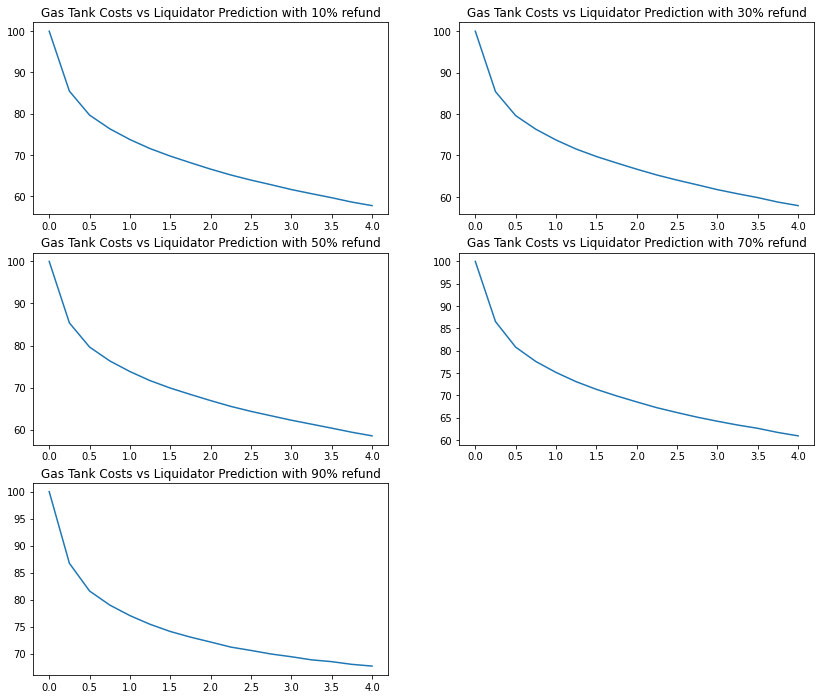

In [13]:
# for each refund rate, show the effect of prediction ability on the slope - want incentives to be aligned
fig, axs = plt.subplots(3,2,figsize=(14,12))
titles = ["Gas Tank Costs vs Liquidator Prediction with {}% refund".format(int(x*100)) for x in [.1, .3, .5, .7, .9]]
for i, ax in enumerate(axs.flat):
    if i == 5:
        ax.axis('off')
        continue
    sns.lineplot(x = np.linspace(0,4, 17), y = refund_rate_to_costs[i] / min(refund_rate_to_costs[i]) * 100, ax=ax) # care about percent reduction
    ax.set_title(titles[i])
    

In [47]:
# randomly sample
params = sample_params()
params

{'upfront_fee': 0.007714695740617783,
 'monthly_opened_streams': 760.0401964911999,
 'average_stream_lifetime': 211.30403230420637,
 'percent_accidently_liquidated_per_month': 11.129293832594646,
 'average_stream_size': 2616.842002957305,
 'liquidator_capital': 88234.05979041352,
 'upfront_hours': 13.573513553571358,
 'refund_rate': 0.9261418901794178,
 'gas_tank_size': 257.1648322144842,
 'max_days_to_return': 131.25371118418548,
 'max_liquidation_wait_time': 24.74926641348698,
 'min_self_liquidation_savings': 8.171831484606143,
 'gas_prediction_ability': 0.6412866733875833}

In [48]:
df = simulate_and_calculate_pl(df, params)

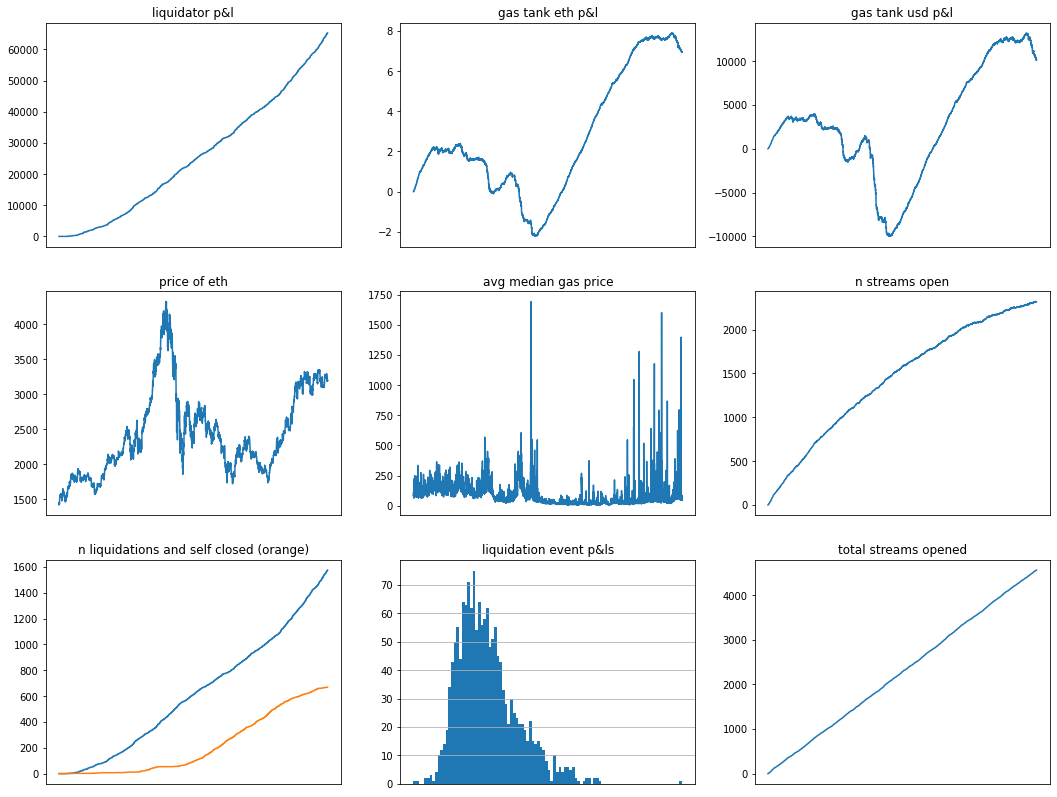

In [49]:
graph_pl(df)